In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
f=open('dataset_2.csv')
df = pd.read_csv(f)
data = df.iloc[:,2:10].values

In [3]:
#获取训练集
def get_train_data(data, batch_size=60,time_step=20,train_begin=0,train_end=5800):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集 
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:7]
       y=normalized_train_data[i:i+time_step,7,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [4]:
#获取测试集
def get_test_data(data,time_step=20,test_begin=5800):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
    test_x,test_y=[],[]  
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:7]
       y=normalized_test_data[i*time_step:(i+1)*time_step,7]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:7]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,7]).tolist())
    return mean,std,test_x,test_y

In [12]:
tf.reset_default_graph()
mean,std,test_x,test_y = get_test_data(data)
batch_index,train_x,train_y=get_train_data(data)
input_size = 7
rnn_unit = 10
output_size = 1
time_step = 20
batch_size = 5780
lr = 0.001
weights={
    'in':tf.Variable(tf.random_normal([input_size,rnn_unit], dtype=tf.float32)),
    'out':tf.Variable(tf.random_normal([rnn_unit,output_size], dtype=tf.float32))
    }
biases={
    'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,], dtype=tf.float32)),
    'out':tf.Variable(tf.constant(0.1,shape=[output_size,], dtype=tf.float32))
    }

In [13]:
def rnn(X):
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicRNNCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [14]:
batch_index,train_x,train_y=get_train_data(data)
train_x = np.array(train_x).reshape([-1,20,7])
train_y = np.array(train_y).reshape([-1,20,1])
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y)).repeat().shuffle(buffer_size=57800).batch(batch_size)
iter = dataset.make_one_shot_iterator()
X, Y = iter.get_next()
pred,_ = rnn(X)
#损失函数
loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
train_op=tf.train.AdamOptimizer(lr).minimize(loss)
saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
#module_file = tf.train.latest_checkpoint("check") 
total_loss = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(2000):
        _, loss_ = sess.run([train_op, loss])
        if i % 100==0:
            print("迭代第："+str(int(i/10))+ "次， Loss为：" + str(loss_))
        if i % 1000==0:
            print("保存模型：",saver.save(sess,'./stock_model/dataset',global_step=int(i/10)))
        total_loss.append(loss_)
plt.figure()
plt.plot(list(range(len(total_loss))), total_loss, color='b')
plt.show()


迭代第：0次， Loss为：7.7487893
保存模型： ./stock_model/dataset-0
迭代第：10次， Loss为：0.1744918
迭代第：20次， Loss为：0.09973923
迭代第：30次， Loss为：0.08530849
迭代第：40次， Loss为：0.07539395
迭代第：50次， Loss为：0.062648386
迭代第：60次， Loss为：0.05380097
迭代第：70次， Loss为：0.040653937
迭代第：80次， Loss为：0.03673282
迭代第：90次， Loss为：0.033621736
迭代第：100次， Loss为：0.02812102
保存模型： ./stock_model/dataset-100
迭代第：110次， Loss为：0.024776492
迭代第：120次， Loss为：0.021995345
迭代第：130次， Loss为：0.018993925
迭代第：140次， Loss为：0.01716301
迭代第：150次， Loss为：0.015300726
迭代第：160次， Loss为：0.013735672
迭代第：170次， Loss为：0.011353519
迭代第：180次， Loss为：0.010446735
迭代第：190次， Loss为：0.010288985


迭代第：0次， Loss为：8.247789
保存模型： ./stock_model/dataset-0
迭代第：10次， Loss为：7.980924
迭代第：20次， Loss为：7.457247
保存模型： ./stock_model/dataset-20
迭代第：30次， Loss为：5.3784266
迭代第：40次， Loss为：4.746299
保存模型： ./stock_model/dataset-40
迭代第：50次， Loss为：8.482743
迭代第：60次， Loss为：5.2664423
保存模型： ./stock_model/dataset-60
迭代第：70次， Loss为：4.3132186
迭代第：80次， Loss为：4.347488
保存模型： ./stock_model/dataset-80
迭代第：90次， Loss为：4.344158
迭代第：100次， Loss为：4.083632
保存模型： ./stock_model/dataset-100
迭代第：110次， Loss为：4.0794153
迭代第：120次， Loss为：3.117173
保存模型： ./stock_model/dataset-120
迭代第：130次， Loss为：3.7165143
迭代第：140次， Loss为：3.9304528
保存模型： ./stock_model/dataset-140
迭代第：150次， Loss为：3.9958155
迭代第：160次， Loss为：4.656645
保存模型： ./stock_model/dataset-160
迭代第：170次， Loss为：3.9583666
迭代第：180次， Loss为：3.206591
保存模型： ./stock_model/dataset-180
迭代第：190次， Loss为：2.2415235
迭代第：200次， Loss为：2.2886252
保存模型： ./stock_model/dataset-200
迭代第：210次， Loss为：2.4675672
迭代第：220次， Loss为：1.6498641
保存模型： ./stock_model/dataset-220
迭代第：230次， Loss为：1.57375
迭代第：240次， Loss为：1.0128

保存模型： ./stock_model/dataset-1900
迭代第：1910次， Loss为：0.020481646
迭代第：1920次， Loss为：0.037868556
保存模型： ./stock_model/dataset-1920
迭代第：1930次， Loss为：0.0130281495
迭代第：1940次， Loss为：0.01567802
保存模型： ./stock_model/dataset-1940
迭代第：1950次， Loss为：0.098477356
迭代第：1960次， Loss为：0.36491695
保存模型： ./stock_model/dataset-1960
迭代第：1970次， Loss为：0.03251414
迭代第：1980次， Loss为：0.056554936
保存模型： ./stock_model/dataset-1980
迭代第：1990次， Loss为：0.05589153


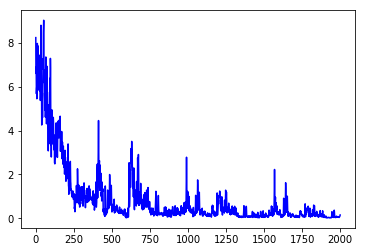

In [45]:
batch_index,train_x,train_y=get_train_data(data)
train_x = np.array(train_x).reshape([-1,20,7])
train_y = np.array(train_y).reshape([-1,20,1])
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y)).repeat().batch(batch_size)
iter = dataset.make_one_shot_iterator()
X, Y = iter.get_next()
pred,_ = rnn(X)
#损失函数
loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
train_op=tf.train.AdamOptimizer(lr).minimize(loss)
saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
#module_file = tf.train.latest_checkpoint("check") 
total_loss = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(2000):
        _, loss_ = sess.run([train_op, loss])
        if i % 10==0:
            print("迭代第："+str(i)+ "次， Loss为：" + str(loss_))
        if i % 20==0:
            print("保存模型：",saver.save(sess,'./stock_model/dataset',global_step=i))
        total_loss.append(loss_)
plt.figure()
plt.plot(list(range(len(total_loss))), total_loss, color='b')
plt.show()
